<div class="alert alert-success">
    <h1 align="center">Lesson 01: Image Classification (Cats vs Dogs)</h1>
    <h3 align="center"><a href="http://www.snrazavi.ir">Seyed Naser RAZAVI</a></h3>
</div>

<h6 align='center'>Kaggle competition: [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition)</h6>

<img src='imgs/catsanddogs.png' width='90%'/>

## Objectives

- Image classification
- Four key components of any ML system (in PyTorch):
 - Data (Images)
 - Model (CNN)
 - Loss (Cross Entropy)
 - Optimization (SGD, Adam, ..)
- Convolutional Neural Networks (CNNs)
- Overfit
- Data augmentation
- Transfer learning

## Image Classification

<img src='imgs/Image_tasks.jpg' width='80%'/>

## Libraries

In [63]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import math
import time
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision
import torchvision.datasets as datasets
import torchvision.models as models
import torchvision.transforms as transforms

# Our libraries
from train import train_model
from model_utils import *
from predict_utils import *
from vis_utils import *

# some initial setup
np.set_printoptions(precision=2)
use_gpu = torch.cuda.is_available()
np.random.seed(1234)

In [64]:
use_gpu

False

## Data

- train: learning the **parameters** of the model.
- valid: learning **hyper-parameters**.
- test
- development

In [71]:
DATA_DIR = '/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/'
sz = 224
batch_size = 32

In [72]:
os.listdir(DATA_DIR)

['train', 'Cat-25000', 'Dog-25000', 'valid']

In [73]:
trn_dir = f'{DATA_DIR}train'
val_dir = f'{DATA_DIR}valid'

In [74]:
os.listdir(trn_dir)

['cat', 'dog']

In [75]:
trn_fnames = glob.glob(f'{trn_dir}/*/*.jpg')
trn_fnames[:5]

['/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train/cat/587.jpg',
 '/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train/cat/668.jpg',
 '/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train/cat/665.jpg',
 '/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train/cat/905.jpg',
 '/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train/cat/798.jpg']

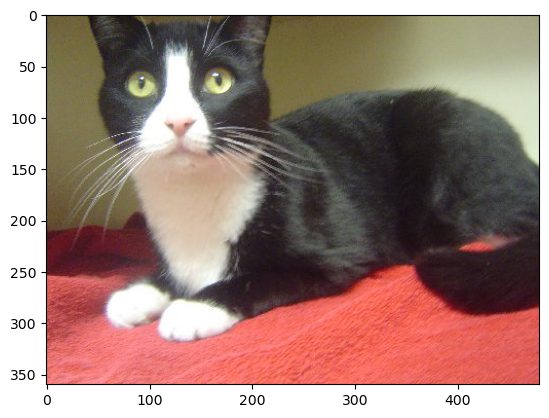

In [76]:
img = plt.imread(trn_fnames[15])
plt.imshow(img);

### Datasets and Dataloaders in PyTorch

- <h6>Dataset</h6>A set of images.
- <h6>Dataloader</h6>Loads data from dataset behind the scene using concurrent threads.

In [77]:
train_ds = datasets.ImageFolder(trn_dir)

In [78]:
train_ds.classes

['cat', 'dog']

In [79]:
train_ds.class_to_idx

{'cat': 0, 'dog': 1}

In [80]:
train_ds.root

'/home/ies/Desktop/Dataset/kagglecatsanddogs_5340/PetImages/train'

In [81]:
# train_ds.imgs

In [82]:
# list(zip(*train_ds.imgs))

In [83]:
type(train_ds.transform)

NoneType

### Transformations

Dataloader object uses these tranformations when loading data.

In [84]:
tfms = transforms.Compose([
    transforms.Resize((sz, sz)),  # PIL Image
    transforms.ToTensor(),        # Tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(trn_dir, transform=tfms)
valid_ds = datasets.ImageFolder(val_dir, transform=tfms)

In [85]:
len(train_ds), len(valid_ds)

(2002, 206)

#### Dataloaders

In [86]:
train_dl = torch.utils.data.DataLoader(train_ds, 
                                       batch_size=batch_size, 
                                       shuffle=True, 
                                       num_workers=4)

valid_dl = torch.utils.data.DataLoader(valid_ds, 
                                       batch_size=batch_size, 
                                       shuffle=False, 
                                       num_workers=4)

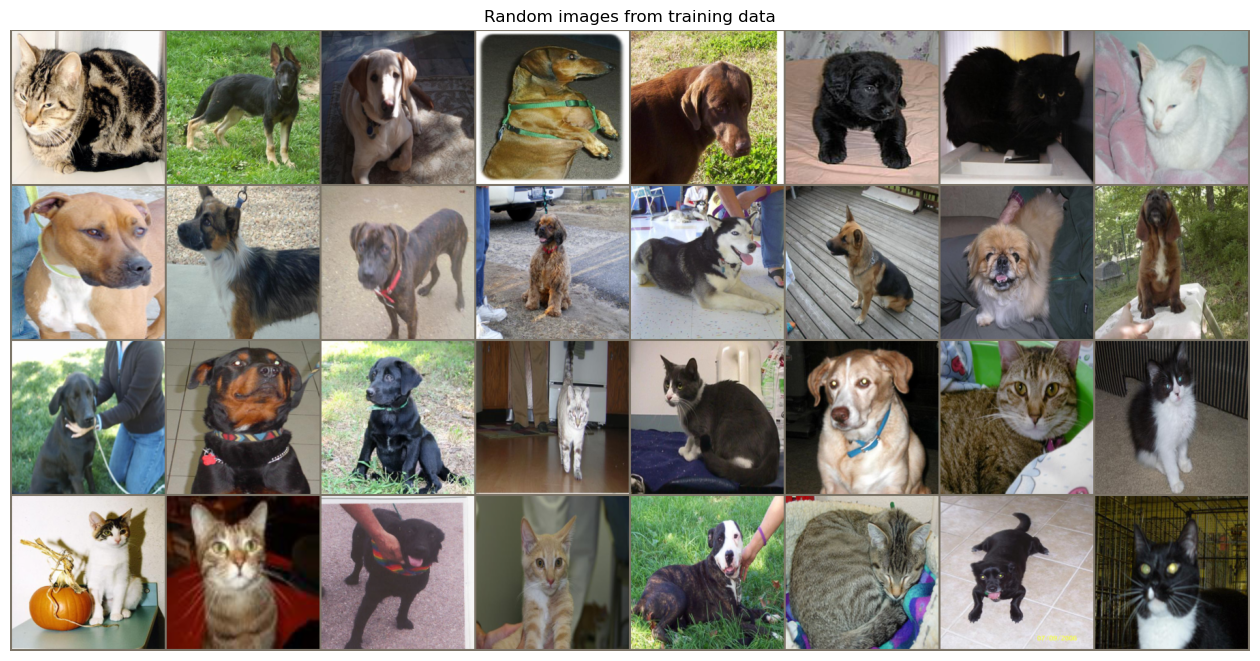

In [87]:
inputs, targets = next(iter(train_dl))
out = torchvision.utils.make_grid(inputs, padding=3)
plt.figure(figsize=(16, 12))
imshow(out, title='Random images from training data')

In [20]:
# ??imshow

## Model: CNN

<img src='imgs/DogAndCats-CNN.jpg' width='100%'/>

In [88]:
class SimpleCNN(nn.Module):
    
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        self.fc = nn.Linear(56 * 56 * 32, 2)
        
    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)            # (bs, C, H,  W)
        out = out.view(out.size(0), -1)  # (bs, C * H, W)
        out = self.fc(out)
        return out

Now, it's time to create the model and to put it on the GPU.

In [89]:
model = SimpleCNN()

# transfer model to GPU, if gpu is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)

In [58]:
model

SimpleCNN(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=100352, out_features=2, bias=True)
)

## Loss function and optimizer

In [90]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

## Train

In [91]:
num_epochs = 3
losses = []

for epoch in range(num_epochs):
    for i, (inputs, targets) in enumerate(train_dl):
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        # forwad pass
        outputs = model(inputs)
        
        # loss
        loss = criterion(outputs, targets)
        losses.append(loss.item())

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        
        # update parameters
        optimizer.step()
        
        # report
        if (i + 1) % 50 == 0:
            print('Epoch [%2d/%2d], Step [%3d/%3d], Loss: %.4f'
                  % (epoch + 1, num_epochs, i + 1, len(train_ds) // batch_size, loss.item()))

Epoch [ 1/ 3], Step [ 50/ 62], Loss: 2.9677
Epoch [ 2/ 3], Step [ 50/ 62], Loss: 0.7656
Epoch [ 3/ 3], Step [ 50/ 62], Loss: 0.5230


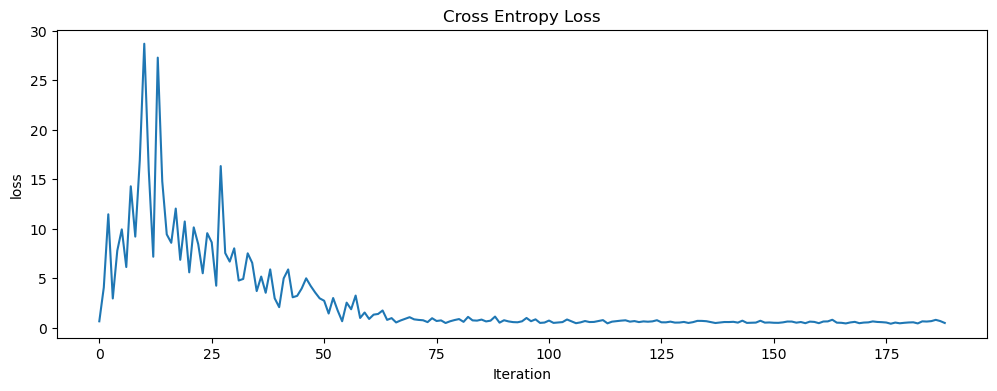

In [92]:
plt.figure(figsize=(12, 4))
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('loss')
plt.title('Cross Entropy Loss')
plt.show()

### Analyze results

#### Accuracy on validation data

In [93]:
def evaluate_model(model, dataloader, device):
    model.eval()  # for batch normalization layers
    corrects = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            corrects += (preds == targets.data).sum()
    
    print('accuracy: {:.2f}'.format(100. * corrects / len(dataloader.dataset)))

In [94]:
evaluate_model(model, valid_dl, device)

accuracy: 62.62


In [96]:
evaluate_model(model, train_dl, device)

accuracy: 75.22


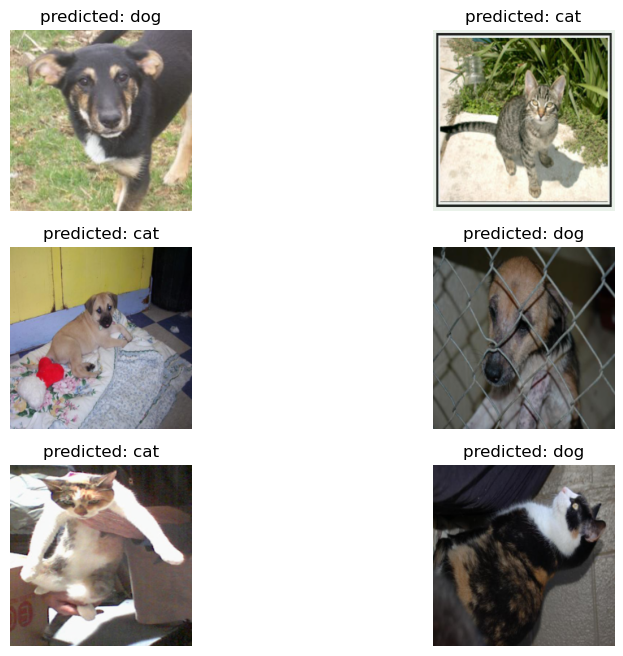

In [97]:
visualize_model(model, train_dl, device)

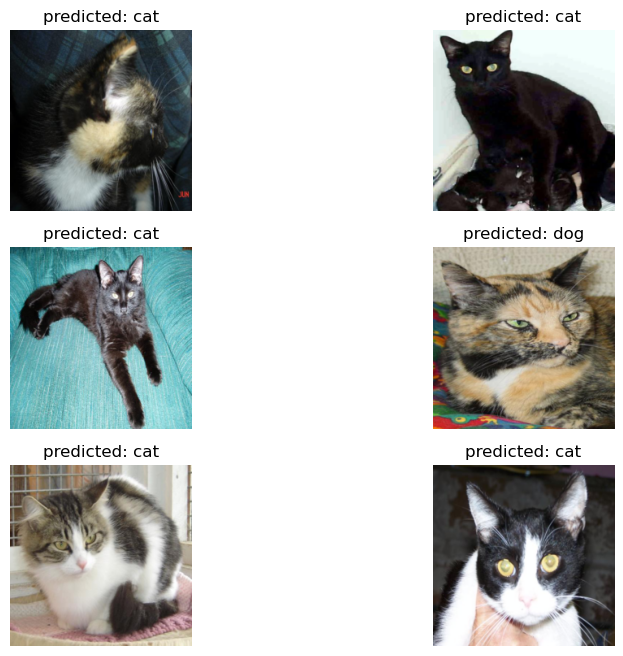

In [98]:
visualize_model(model, valid_dl, device)

100%|██████████| 13/13 [00:05<00:00,  2.36it/s]


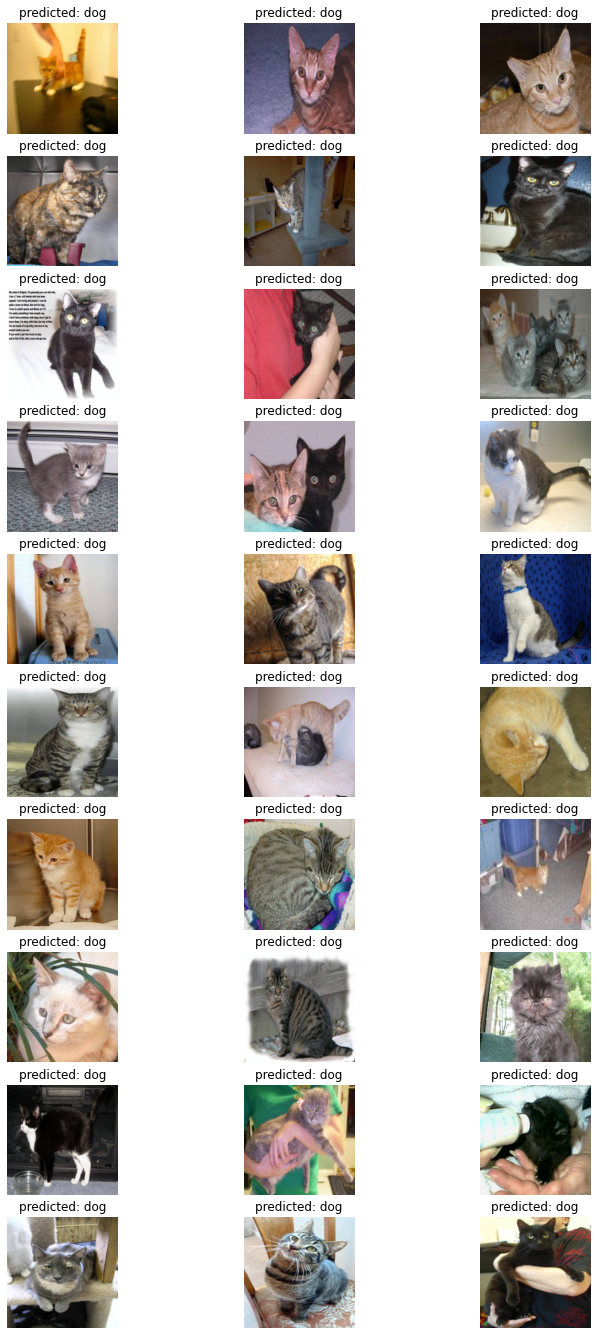

42 images out of 400 were misclassified.


In [32]:
plot_errors(model, valid_dl, device)

#### Confusion matrix

100%|█████████████████████████████████████████████| 7/7 [00:02<00:00,  3.06it/s]


[[0.62 0.38]
 [0.37 0.63]]


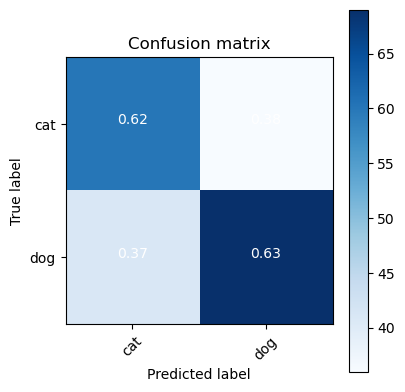

In [99]:
y_pred, y_true = predict_class(model, valid_dl, device)
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, train_ds.classes, normalize=True, figsize=(4, 4))

## Overfit

<div class="alert alert-success">
    <strong>What is OVERFIT? </strong>
    <ul>
        <li>The most important concept in ML!</li>
        <li>Simply, it means that your model is too complex for your problem.</li>
    </ul>
</div>

<h6>What we can do about it?</h6>

- Regularization
- Dropout
- Data Augmentation
- Transfer Learning

## Data Augmentation

<img src='imgs/Augmentation.jpg' width='90%'/>

<h6>Possible Transformations:</h6>
- Scaling
- Rotation
- Translation
- Flip horizontaly
- Random Crop
- Color jitter
- many more!

<img src='imgs/Augmentation-Examples.jpg' width='75%'/>

In [100]:
# Data augmentation and normalization for training
train_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.1, 0.1, 0.1, 0.01),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Just normalization for validation
valid_transforms = transforms.Compose([
    transforms.Resize((sz, sz)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_ds = datasets.ImageFolder(f'{DATA_DIR}train', train_transforms)
valid_ds = datasets.ImageFolder(f'{DATA_DIR}valid', valid_transforms)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = torch.utils.data.DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

train_ds_sz = len(train_ds)
valid_ds_sz = len(valid_ds)

print('Train size: {}\nValid size: {} ({:.2f})'.format(train_ds_sz, valid_ds_sz, valid_ds_sz/(train_ds_sz + valid_ds_sz)))

class_names = train_ds.classes

Train size: 2002
Valid size: 206 (0.09)


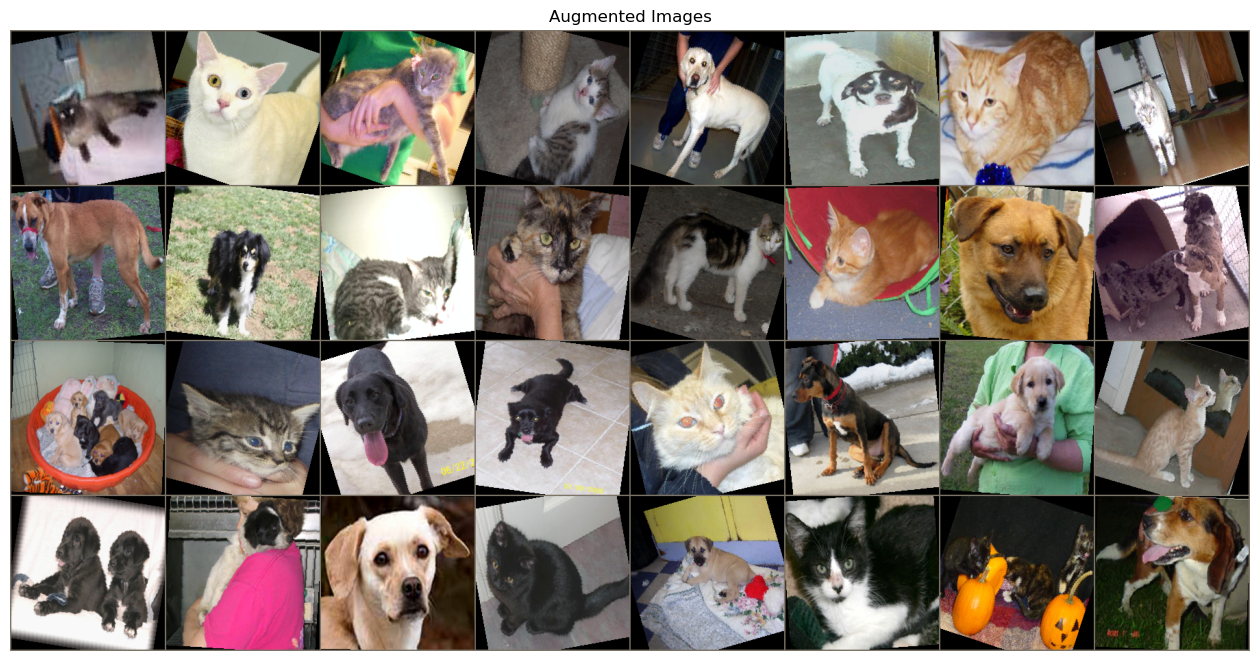

In [101]:
inputs, targets = next(iter(train_dl))     # Get a batch of training data
out = torchvision.utils.make_grid(inputs)  # Make a grid from batch
plt.figure(figsize=(16., 12.))
imshow(out, title='Augmented Images');

#### Look at the sizes of the images

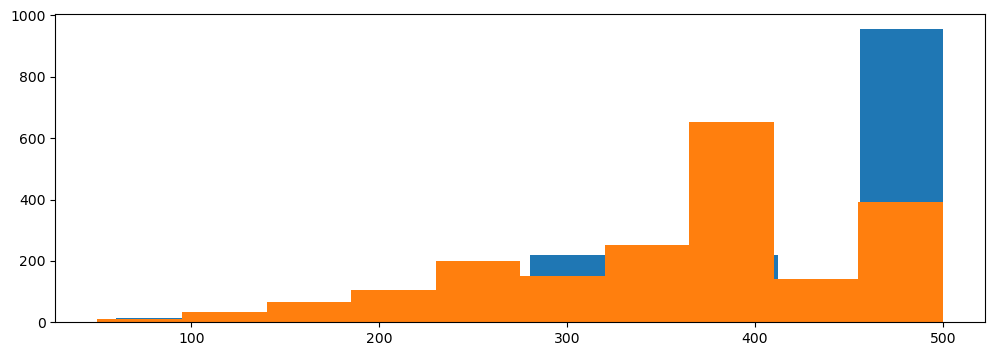

In [102]:
fnames = glob.glob(f'{trn_dir}/*/*.jpg')
sizes = [Image.open(f).size for f in fnames]

hs, ws = list(zip(*sizes))

plt.figure(figsize=(12., 4.))
plt.hist(hs)
plt.hist(ws);

In [103]:
# create model
model = SimpleCNN()
model = model.to(device)
    
# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)

# train
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, num_epochs=5)

Epoch 1/5
----------
  train Loss: 6.65831 Acc: 0.51998
  valid Loss: 1.85863 Acc: 0.51942

Epoch 2/5
----------
  train Loss: 1.00941 Acc: 0.56543
  valid Loss: 0.66578 Acc: 0.59223

Epoch 3/5
----------
  train Loss: 0.64456 Acc: 0.63586
  valid Loss: 0.65587 Acc: 0.54854

Epoch 4/5
----------
  train Loss: 0.61478 Acc: 0.65285
  valid Loss: 0.71015 Acc: 0.55340

Epoch 5/5
----------
  train Loss: 0.62248 Acc: 0.65784
  valid Loss: 0.63840 Acc: 0.63592

Training complete in 6m 59s
Best val Acc: 0.6359


## Transfer Learning

- Use a CNN already trained on different data (e.g., [ImageNet](http://www.image-net.org/))
- Just Train the classifier weights (Last Layer)

<img src='imgs/transfer-learning.jpg' width='80%'/>

In [104]:
# load pre-trained ResNet18
model = load_pretrained_resnet50(model_path=None, num_classes=2)
model = model.to(device)

# loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.9)

/home/ies/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ies/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/ies/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:07<00:00, 13.0MB/s]


In [105]:
model = train_model(model, train_dl, valid_dl, criterion, optimizer, device, scheduler, num_epochs=2)

Epoch 1/2
----------
  train Loss: 0.16550 Acc: 0.93856
  valid Loss: 0.01807 Acc: 1.00000

Epoch 2/2
----------
  train Loss: 0.04074 Acc: 0.98501
  valid Loss: 0.01409 Acc: 0.99515

Training complete in 14m 49s
Best val Acc: 1.0000


In [107]:
evaluate_model(model, valid_dl, device)

accuracy: 99.51


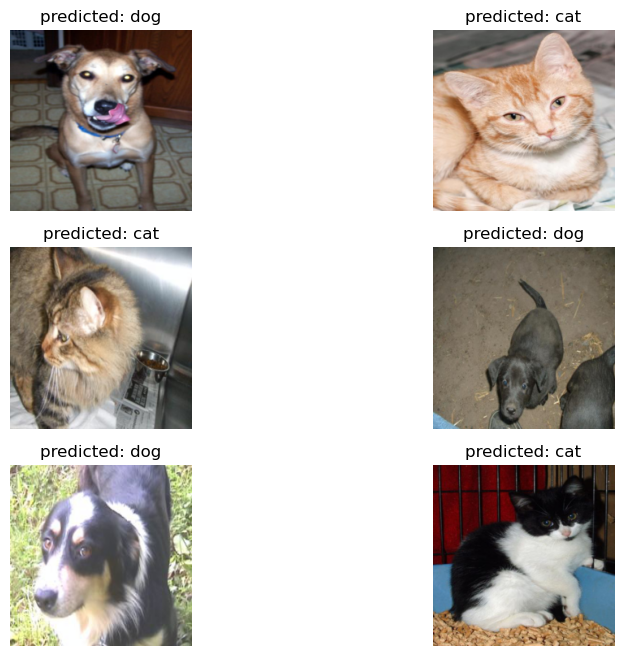

In [108]:
visualize_model(model, valid_dl, device, num_images=6)

100%|█████████████████████████████████████████████| 7/7 [00:15<00:00,  2.17s/it]


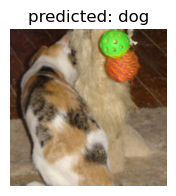

1 images out of 206 were misclassified.


In [109]:
plot_errors(model, valid_dl, device)

## PROGRAMMING ASSIGNMENT 1

<div class="alert alert-success">
    <strong>[Plant Seeldlings Competition](https://www.kaggle.com/c/plant-seedlings-classification)</strong>
    <img src='imgs/PlantSeedling.png'/>
    <ul>
        <li><strong>Objective:</strong> getting a rank among top 50% in LB.</li>
        <li><strong>Ideas:</strong> different augmentations, different architectures, etc.</li>
        <li><strong>Important:</strong> share your ideas and progress on Piazza.</li>
    </ul>
</div>